In [65]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
%matplotlib inline

In [66]:
#Set working directory and names
name = 'BoxModel'
ws = 'D:/Chelsea/Projects/DelawareStream/FloPy/' + name
if not os.path.exists(ws): #make sure workspace directory exists
    os.makedirs(ws)
exe_name_mf = os.path.abspath('D:/Chelsea/Projects/DelawareStream/Script/Executables/mf2005')
exe_name_mt = os.path.abspath('D:/Chelsea/Projects/DelawareStream/Script/Executables/mt3dms')

In [67]:
# All inputs
len_units = 'meters'
time_units = 'days'

# Grid
Lx = 1000. #total width across rows of entire model
Ly = 1000. #total width across columns
ztop = 10. #top elevation of layer 1
zbot = -100. #bottom elevation
nlay = 5 #number of layers
nrow = 10 #number of rows
ncol = 10 #number of columns
delr = Lx / ncol #the cell width along rows
delc = Ly / nrow #the cell width along columns
delv = (ztop - zbot) / nlay #elevation change from top to bottom of model
botm = np.linspace(ztop, zbot, nlay + 1) # bottom elevation of each layer including top elevation 

# Flow
hk = 1. #hydraulic conductivity along rows
vka = 1. #vertical hydraulic conductivity
sy = 0.1 #specific yield
ss = 1.e-4 #specific storage
laytyp = np.zeros(nlay, dtype=np.int) #[1,0,0,0,0]
laytyp[0] =1  #layer type, 0 - confined, >0 - convertible, <0 - convertiable unless THICKSTRT

# Boundaries
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #boundary variable... one value for every cell... if >0 cell is active, if =0 cell is inactive, if <0 cell has constant head. 
strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32) #initial starting head... one value for every cell

# Time 
nper = 3 #number of stress periods
perlen_num = 100 #[1, 100, 100] 
perlen = np.ones(nper, dtype=np.int) * perlen_num #length of stress period
perlen[0] = 1 #number of time steps in each stress period
nstp = perlen
steady = [False] * nper
steady[0] = True #transient or steady state
endtime = np.cumsum(perlen)

# Wells
pumping_rate = 60. #length3/time
screen_layer = 1
wellx = nrow/2 #- 1
welly = ncol/2 #- 1
wel_sp1 = [[screen_layer, wellx, welly, 0.]] #layer, row, col, volumetric recharge rate (+ is recharge, and - is pumping)
wel_sp2 = [[screen_layer, wellx, welly, 100.]]
wel_sp3 = [[screen_layer, wellx, welly, pumping_rate]]
#wel_sp4 = [[screen_layer, wellx, welly, 50.]]
#wel_sp5 = [[screen_layer, wellx, welly, -pumping_rate]]
stress_period_data1 = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}#, 3: wel_sp4, 4: wel_sp5}

###########################################################################################################
# Transport
v = 1. / 3. #groundwater seepage velocity, L/T
prsity = 0.3 #porosity
q = v * prsity #flux
al = 10. #longitudinal dispersivity, L
trpt = .3 #ratio of transverse to longitudinal dispersivity
q0 = 1. #volumetric injection rate, L3/T
c0 = 10000. #concentration of injected water, ppm
sconc = 0 #starting concentration

# Observation points
obs = [[1 - 1, 5 - 1, 5 - 1],[1 - 1, 8 - 1, 5 - 1],[1 - 1, 3 - 1, 5 - 1]] #create observation points

# Advection
mixelm = 1 # integer flag for the advection solution option
dceps = 1.e-5 #small relative cell concentration gradient below which advection transport is considered
nplane = 1 #flag indicating whether random or fixed pattern is selected for initial placement (0 = random, 1 = 2D, 2 = 3D)
npl = 0 #num of initial particles per cell to placed at cells where <= decps
nph = 16 #num of initial particles per cell to placed at cells where >= decps
npmin = 2 #min num of particles allowed per cell
npmax = 32 #max num of particles allowed per cell
dchmoc=1.e-3 #critical Relative Concentration Gradient for controlling use of either MOC or MMOC in the HMOC solution scheme.
nlsink = nplane #flag indicating whether the random or fixed pattern is selected for initial placement of particles to approximate sink cells
npsink = nph #number of particles used to approximate sink cells in the MMOC scheme. 

# Stress period
spd = {0:[0, 4, 4, sconc, 2], 1:[0, 4, 4, c0, 2], 2:[0, 4, 4, c0, 2]}#,
     # 3:[0, 4, 4, c0, 2], 4:[0, 4, 4, c0, 2]} #stress period, where last value is the type of cell 2 = well

In [68]:
# Stress period

# Make list for stress period 1
stageleft = 10.
stageright = 0.
bound_sp1 = []
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc #hydraulic conductivity * area of left face 
    condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft]) #layer, row, column, head on boundary, and conductance
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])

# Make list for stress period 2
# In the stress period 2, the head drops to 0 and becomes less conductive at the right boundary.
stageleft = 10.
stageright = 0.
condleft = hk * (stageleft - zbot) * delc #hydraulic conductivity * area of left face 
condright = hk * (stageright - zbot) * delc
bound_sp2 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])

stress_period_data = {0: bound_sp1, 1: bound_sp2}

In [69]:
# Model Files
mf = flopy.modflow.Modflow(modelname=name, model_ws=ws, exe_name=exe_name_mf)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:], 
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53) 
pcg = flopy.modflow.ModflowPcg(mf) 
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data1)

# Output control
stress_period_data = {}
for kper in range(nper): #for each stress period
    for kstp in range(nstp[kper]): #for each time period
        stress_period_data[(kper, kstp)] = ['save head',
                                            'save drawdown',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data, compact=True)

lmt = flopy.modflow.ModflowLmt(mf)

mf.write_input()
success, mfoutput = mf.run_model(silent=True, pause=False)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

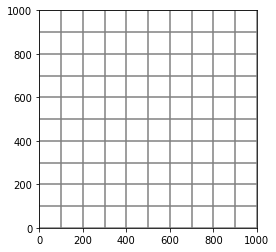

In [70]:
# Plotting
mm = flopy.plot.PlotMapView(model=mf)
plota = mm.plot_grid()

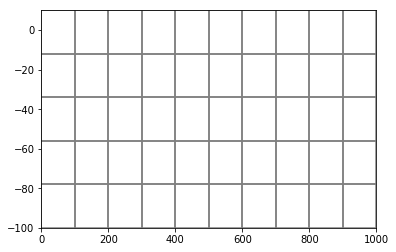

In [75]:
# Plotting
mm2 = flopy.plot.PlotCrossSection(model=mf, line={'row': 2})
plotb = mm2.plot_grid()

In [77]:
# Add MT3DMS components
mt = flopy.mt3d.Mt3dms(modelname=name, model_ws=ws, exe_name=exe_name_mt, modflowmodel=mf)
btn = flopy.mt3d.Mt3dBtn(mt, icbund=1, prsity=prsity, sconc=sconc, obs=obs)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, dceps=dceps, nplane=nplane, 
                             npl=npl, nph=nph, npmin=npmin, npmax=npmax,
                             nlsink=nlsink, npsink=npsink, percel=0.5)
dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)

# no user-specified concentrations associated with boundary conditions

mxss = 1000 #the maximum number of all point sinks and sources included in the flow model
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd, mxss=mxss)
gcg = flopy.mt3d.Mt3dGcg(mt)
mt.write_input()

fname = os.path.join(ws+'/MT3D001.UCN')
if os.path.isfile(fname):
    os.remove(fname)
mt.run_model(silent=False, pause=False, normal_msg = 'normal termination')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:/Chelsea/Projects/DelawareStream/FloPy/BoxModel/MT3D001.UCN'

In [ ]:
# Create the headfile and budget file objects
headobj = bf.HeadFile(ws + '/' + name + '.hds')
times = headobj.get_times()
cbb = bf.CellBudgetFile(ws + '/' + name + '.cbc')

fname = os.path.join(ws, 'MT3D001.UCN')
ucnobj = flopy.utils.UcnFile(fname)
timesconc = ucnobj.get_times()
conc = ucnobj.get_alldata()

fname = os.path.join(ws, 'MT3D001.OBS')
if os.path.isfile(fname):
    cvt = mt.load_obs(fname)
else:
    cvt = None

fname = os.path.join(ws, 'MT3D001.MAS')
mvt = mt.load_mas(fname)
cvt

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 2, 1)
#mf, mt, conc, cvt, mvt   = p06('p06', 1, 56.25)
x = cvt['time']
y = cvt['(1, 5, 5)']
ax.plot(x, y, label='1, 5, 5', marker='^')

#x = cvt['time']
#y = cvt['(1, 8, 5)']
#ax.plot(x, y, label='1, 8, 5', marker='s')

#x = cvt['time']
#y = cvt['(1, 3, 5)']
#ax.plot(x, y, label='1, 3, 5', marker='x')

#plt.xlim(0, 10)
#plt.ylim(0, 100.0)
plt.xlabel('TIME, IN YEARS')
plt.ylabel('NORMALIZED CONCENTRATION, IN PERCENT')
plt.legend()

In [ ]:
# Plot the head versus time
# This is the well spot, notice how pumping started ony in the last stress period
idx = (0, int(nrow/2) - 1, int(ncol/2) - 1)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time')
plt.ylabel('head')
plt.plot(ts[:, 0], ts[:, 1], 'bo-')
plt.savefig(ws+'/'+ name + '.png')

In [62]:
ws+'/Figures/'+ name + '.png'

'D:/Chelsea/Projects/DelawareStream/FloPy/BoxModel/Figures/BoxModel.png'